In [5]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import astroML
from tqdm import tqdm

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

# astropy
from astropy import units as u
from astropy import constants

# density estimation
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

import emcee
#import pymc3
import corner

import dynesty

import sklearn
from sklearn import manifold
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Dimensional reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA

# Cross-Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

# Regularization
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

# Classification
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score # return the fraction of correctly identified samples
from astroML.utils import split_samples, completeness_contamination

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier

## Galaxies vs Quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

Some figures from the second paper:

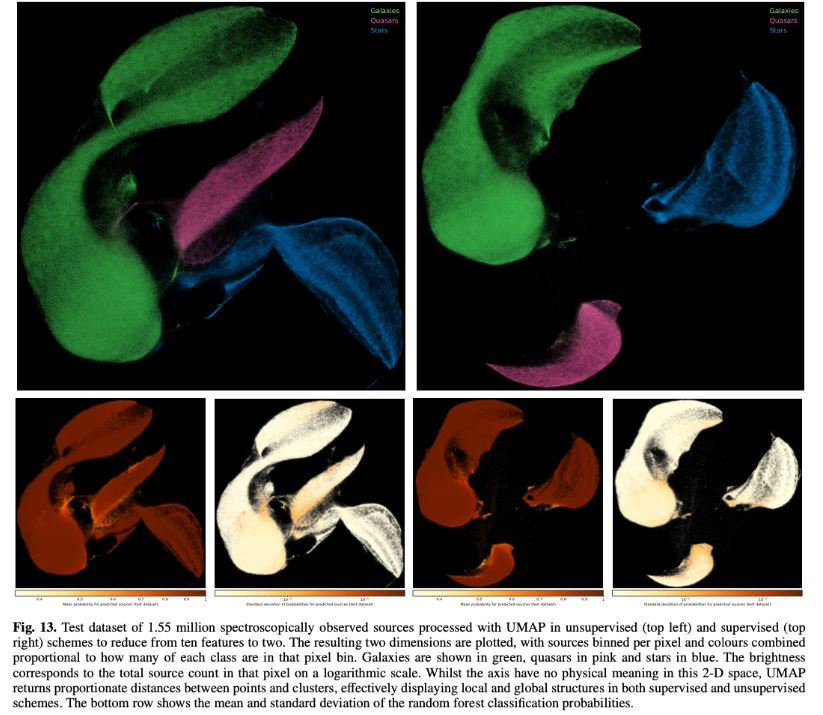

SDSS observed in four bands:
    
![](https://speclite.readthedocs.io/en/latest/_images/sdss2010.png) 
    

#### Tasks

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...



##### Food for thought


- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

In [6]:
# read the data
data = pd.read_csv('galaxyquasar-Copy1.csv')

data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [7]:
# create the color arrays
u_g, g_r, r_i, i_z = np.array([(data['u']-data['g']), (data['g']-data['r']), (data['r']-data['i']), (data['i']-data['z'])])

# assign the 0 to galaxyes and 1 to QSO
le = LabelEncoder()

data['class'] = le.fit_transform(data['class'])
labels = le.inverse_transform(data['class'])
class_names = le.classes_
print(class_names)

data

['GALAXY' 'QSO']


,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,1,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,0,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,0,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,0,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,1,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,0,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,0,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,0,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,0,0.112571,0.000009


Text(0, 0.5, 'counts')

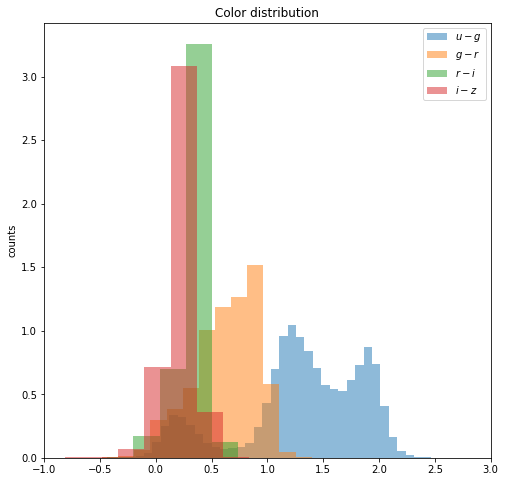

In [8]:
fig = plt.figure(figsize=(8,8))
plt.hist(u_g,density=True,histtype='stepfilled',alpha=0.5,label='$u-g$',bins=100)
plt.hist(g_r,density=True,histtype='stepfilled',alpha=0.5,label='$g-r$',bins=100)
plt.hist(r_i,density=True,histtype='stepfilled',alpha=0.5,label='$r-i$',bins=100)
plt.hist(i_z,density=True,histtype='stepfilled',alpha=0.5,label='$i-z$',bins=100)

plt.xlim(-1,3)
plt.legend()
plt.title('Color distribution')
plt.ylabel('counts')

In [9]:
X = np.array([u_g, g_r, r_i, i_z]).T
y = np.array(data['class'])

X.shape

(50000, 4)

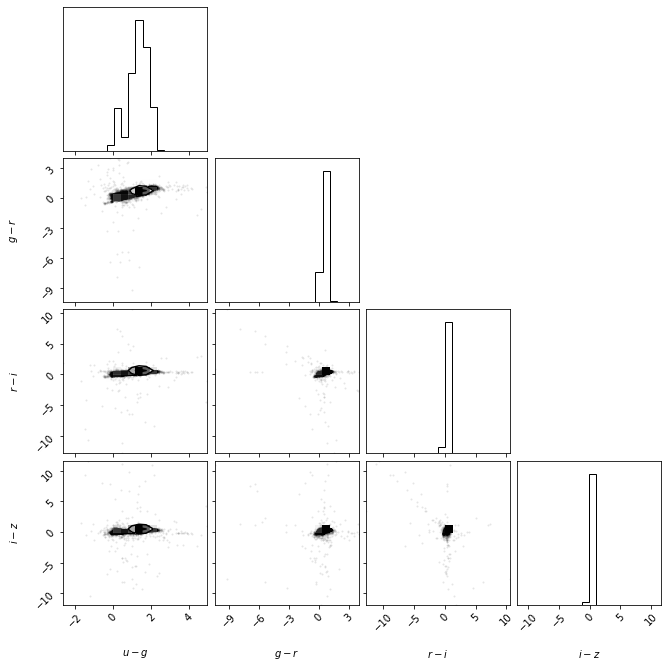

In [10]:
corner.corner(X,labels=('$u-g$', '$g-r$', '$r-i$', '$i-z$'));

We can notice both in the histogram at the beginning and in the corner plot above a bimodality in $u-g$, probably due to quasars and galaxies. We can try to plot the histogram of the $u-g$ individually, labelling the two different distributions:

In [11]:
galaxy_idx = np.array(data['class']==0)
qso_idx = np.array(data['class']==1)

(-1.0, 3.0)

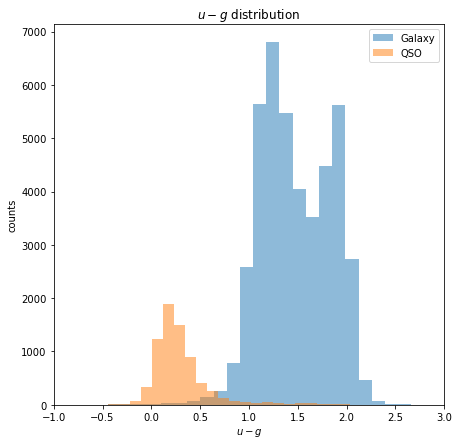

In [12]:
fig = plt.figure(figsize=(7,7))

plt.hist(u_g[galaxy_idx],label='Galaxy',alpha=0.5,bins=50);
plt.hist(u_g[qso_idx],label='QSO',alpha=0.5,bins=50);

plt.xlabel(r'$u-g$')
plt.ylabel('counts')
plt.title(r'$u-g$ distribution')
plt.legend()
plt.xlim(-1,3)

Let's start with classification

In [13]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.25,train_size=0.75)

#### Gaussian Naive Bayes

In [14]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train,y_train)
y_pred_gnb = gnb_clf.predict(X_test)
y_prob_gnb = gnb_clf.predict_proba(X_test)

In [15]:
confusion_matrix(y_test,y_pred_gnb)

array([[10495,   226],
       [  139,  1640]], dtype=int64)

In [16]:
completeness_gnb, contamination_gnb = astroML.utils.completeness_contamination(y_pred_gnb, y_test)

print("completeness", completeness_gnb)
print("contamination", contamination_gnb)

completeness 0.9218662169758292
contamination 0.12111468381564845


In [17]:
accuracy_gnb = accuracy_score(y_test,y_pred_gnb)
print('classification accuracy:',accuracy_gnb)

classification accuracy: 0.9708


Let's study which is the most relevant color for the classification

In [18]:
def compute_GNB(Ncolors,combination,color_names):

    predictions = []
    scores_c = []
    c_names = []

    for comb in combination:
        predictions.append([])
        scores_c.append([])
        c_names.append(color_names[comb])
        for nc in Ncolors:
            clf = GaussianNB()
            clf.fit(X_train[:,comb][:, :nc], y_train) # comb order the array; nc select the n_colors to consider
            y_pred = clf.predict(X_test[:,comb][:, :nc])

            predictions[-1].append(y_pred)
            scores_c[-1].append(accuracy_score(y_test,y_pred))

    return predictions,scores_c,c_names

In [19]:
# iterate over different possible combinations of colors
arr_comb = np.array([[0,1,2,3], [3,0,1,2], [2,3,0,1],[1,2,3,0]])

color_names = np.array(['u-g', 'g-r', 'r-i', 'i-z'])

# predict labels for different numbers of colors
y_pred_col_GNB,scores_col,colors = compute_GNB(np.arange(1,5),arr_comb,color_names)

In [20]:
completeness_col, contamination_col = completeness_contamination(y_pred_col_GNB,y_test)

Text(0, 0.5, 'completeness')

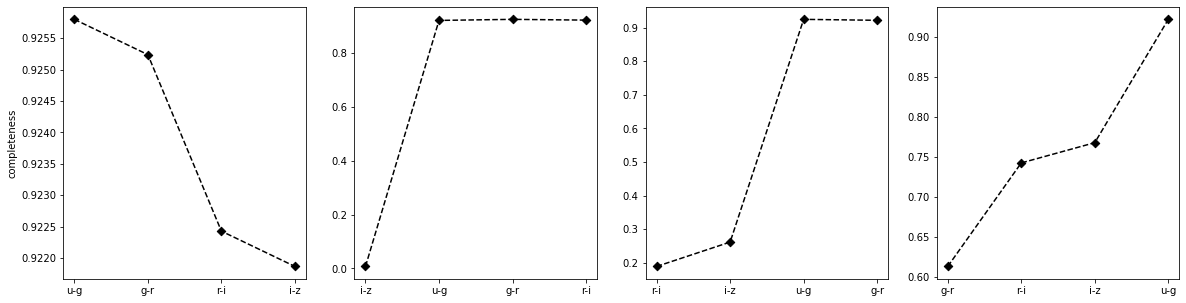

In [21]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))
N_col = np.arange(4) + 1
for i in range(4):
    ax.flatten()
    ax[i].plot(colors[i],completeness_col[i],color='black',ls='--')
    ax[i].scatter(colors[i],completeness_col[i],marker='D',color='black')
    
ax[0].set_ylabel('completeness')

Text(0, 0.5, 'contamination')

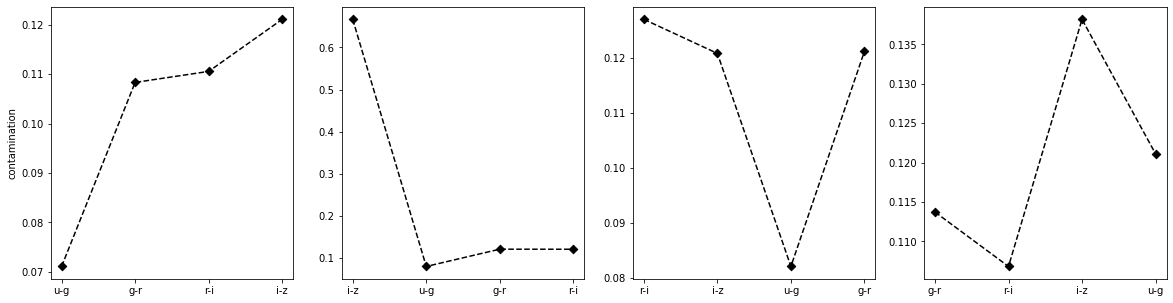

In [22]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))
N_col = np.arange(4) + 1
for i in range(4):
    ax.flatten()
    ax[i].plot(colors[i],contamination_col[i],color='black',ls='--')
    ax[i].scatter(colors[i],contamination_col[i],marker='D',color='black')
    
ax[0].set_ylabel('contamination')

As expected, $u-g$ is the one contributing the most to the classification performance

#### Linear Discriminant Analysis

In [23]:
lda_clf = LDA()
lda_clf.fit(X_train,y_train)
y_pred_lda = lda_clf.predict(X_test)
y_prob_lda = lda_clf.predict_proba(X_test)

In [24]:
confusion_matrix(y_test,y_pred_lda)

array([[10607,   114],
       [  128,  1651]], dtype=int64)

In [25]:
completeness_lda, contamination_lda = astroML.utils.completeness_contamination(y_pred_lda, y_test)

print("completeness", completeness_lda)
print("contamination", contamination_lda)

completeness 0.9280494659921305
contamination 0.06458923512747876


In [26]:
accuracy_lda = accuracy_score(y_test,y_pred_lda)
print('classification accuracy:',accuracy_lda)

classification accuracy: 0.98064


#### Quadratic Discriminant Analysis

In [27]:
qda_clf = QDA()
qda_clf.fit(X_train,y_train)
y_pred_qda = qda_clf.predict(X_test)
y_prob_qda = qda_clf.predict_proba(X_test)

In [28]:
confusion_matrix(y_test,y_pred_qda)

array([[10582,   139],
       [  127,  1652]], dtype=int64)

In [29]:
completeness_qda, contamination_qda = astroML.utils.completeness_contamination(y_pred_qda, y_test)

print("completeness", completeness_qda)
print("contamination", contamination_qda)

completeness 0.9286115795390669
contamination 0.07761027359017308


In [30]:
accuracy_qda = accuracy_score(y_test,y_pred_qda)
print('classification accuracy:',accuracy_qda)

classification accuracy: 0.97872


#### GMM Bayes Classification

In [31]:
# find the best number of components through cross-validation:
# perform Classification
scores_gmm = []
nvals = np.arange(2,10)
for n in nvals:
    clf = GMMBayes(n_components=n)
    CVpred = cross_val_predict(clf, X_train, y_train) # use only the train data to cross-validate
    scores_gmm.append(accuracy_score(y_train, CVpred)) 

max score is for n = 6


Text(0.5, 1.0, 'Classification accuracy vs $N_{comp}$')

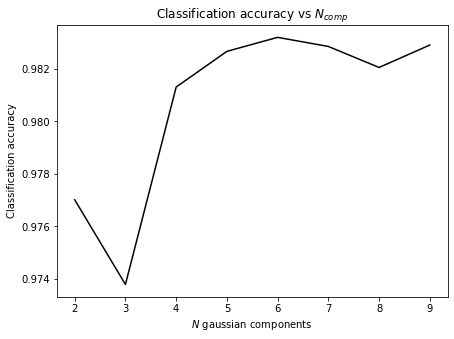

In [32]:
print("max score is for n =",nvals[np.argmax(scores_gmm)])

# Plot number of neighbors vs score
fig = plt.figure(figsize=(7, 5))

plt.plot(nvals,scores_gmm,color='black')
plt.xlabel('$N$ gaussian components')
plt.ylabel('Classification accuracy')
plt.title(r'Classification accuracy vs $N_{comp}$')

In [34]:
best_N = nvals[np.argmax(scores_gmm)]

gmm_clf = GMMBayes(n_components=best_N)
gmm_clf.fit(X_train,y_train)
y_pred_gmm = gmm_clf.predict(X_test)
y_prob_gmm = gmm_clf.predict_proba(X_test)

In [35]:
confusion_matrix(y_test,y_pred_gmm)

array([[10634,    87],
       [  127,  1652]], dtype=int64)

In [36]:
completeness_gmm, contamination_gmm = astroML.utils.completeness_contamination(y_pred_gmm, y_test)

print("completeness", completeness_gmm)
print("contamination", contamination_gmm)

completeness 0.9286115795390669
contamination 0.050028752156411734


In [37]:
accuracy_gmm = accuracy_score(y_test,y_pred_gmm)
print('classification accuracy:',accuracy_gmm)

classification accuracy: 0.98288


#### K-Nearest neighbor classifier

In [38]:
# find the best number of components through cross-validation:
# perform Classification
scores_knc = []
kvals = np.arange(1,20)
for k in kvals:
    clf = KNeighborsClassifier(n_neighbors=k)
    CVpredk = cross_val_predict(clf, X_train, y_train)
    scores_knc.append(accuracy_score(y_train, CVpredk)) 

max score is for k = 10


Text(0.5, 1.0, 'Classification accuracy vs $k_{neighbors}$')

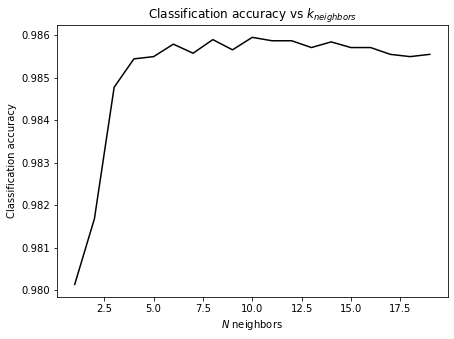

In [39]:
print("max score is for k =",kvals[np.argmax(scores_knc)])

# Plot number of neighbors vs score
fig = plt.figure(figsize=(7, 5))

plt.plot(kvals,scores_knc,color='black')
plt.xlabel('$N$ neighbors')
plt.ylabel('Classification accuracy')
plt.title(r'Classification accuracy vs $k_{neighbors}$')

In [40]:
best_k = kvals[np.argmax(scores_knc)]

knc_clf = KNeighborsClassifier(n_neighbors=best_k)
knc_clf.fit(X_train,y_train)
y_pred_knc = knc_clf.predict(X_test)
y_prob_knc = knc_clf.predict_proba(X_test)

In [41]:
confusion_matrix(y_test,y_pred_knc)

array([[10651,    70],
       [  119,  1660]], dtype=int64)

In [42]:
completeness_knc, contamination_knc = astroML.utils.completeness_contamination(y_pred_knc, y_test)

print("completeness", completeness_knc)
print("contamination", contamination_knc)

completeness 0.9331084879145587
contamination 0.04046242774566474


In [43]:
accuracy_knc = accuracy_score(y_test,y_pred_knc)
print('classification accuracy:',accuracy_knc)

classification accuracy: 0.98488


### ROC curves

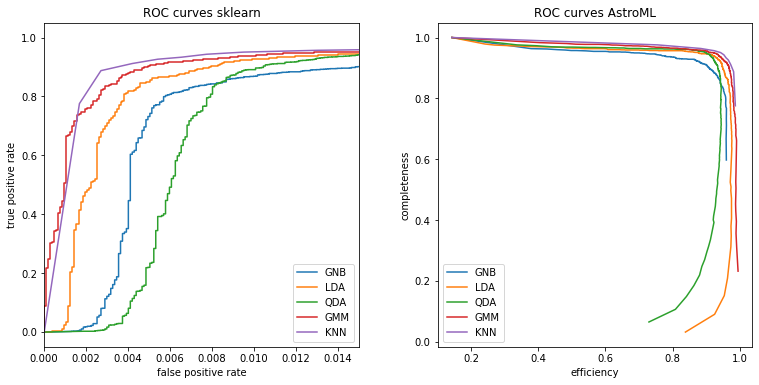

In [44]:
methods_clf = np.array(['GNB','LDA','QDA','GMM','KNN'])
y_probs = np.array([y_prob_gnb,y_prob_lda,y_prob_qda,y_prob_gmm,y_prob_knc])

#plot
fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)
    
# ax1 will show roc curves
ax1 = plt.subplot(131)

# ax2 will show completeness/efficiency
ax2 = plt.subplot(132)

for label, y_prob in zip(methods_clf,y_probs):
    # sklearn
    fpr, tpr, thresh = roc_curve(y_test, y_prob[:,1])
    
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    #astroML
    thresholds = np.linspace(0, 1, 1001)[:-1] # grid of thresholds
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob[:,-1] >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
        
    
    # ROC curves sklearn
    ax1.plot(fpr,tpr,label=label)
    #plt.xscale('log')
    ax1.set_xlim(0,0.015)
    ax1.set_xlabel('false positive rate')
    ax1.set_ylabel('true positive rate')
    ax1.set_title('ROC curves sklearn')
    ax1.legend()
    
    ax2.plot(1-cont, comp,label=label)
    ax2.set_title('ROC curves AstroML')
    ax2.set_xlabel('efficiency')
    ax2.set_ylabel('completeness')
    ax2.legend()

#### PCA to reduce the dimensionality

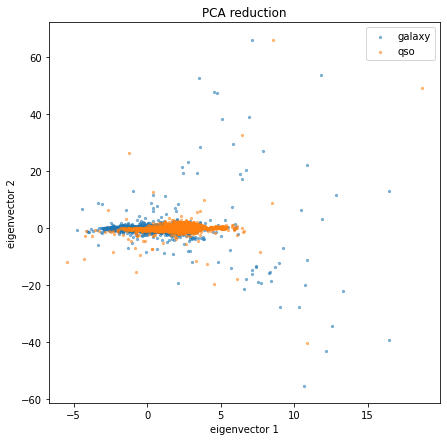

In [45]:
# rescale the X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# pca
pca = PCA()
pca.fit(X_scaled)
X_transformed = pca.transform(X_scaled)

fig = plt.figure(figsize=(7,7))

for i,cl,lab in zip(range(2),np.array([galaxy_idx,qso_idx]),np.array(['galaxy','qso'])):
    plt.scatter(X_transformed[:,0][cl],X_transformed[:,1][cl],color='C%i'%i,label=lab,s=5,alpha=0.5)

plt.title('PCA reduction')
plt.xlabel('eigenvector 1')
plt.ylabel('eigenvector 2')
plt.legend()

In [46]:
evals = pca.explained_variance_ratio_
print('Explained variance ratio by 2 components:',np.sum(evals[:2]),'%')
print('Single components contribution:',evals,'%')

Explained variance ratio by 2 components: 0.8433377122225889 %
Single components contribution: [0.55399123 0.28934648 0.11321224 0.04345004] %


Text(0.5, 1.0, 'Variance embedded in the cumulative PCA components')

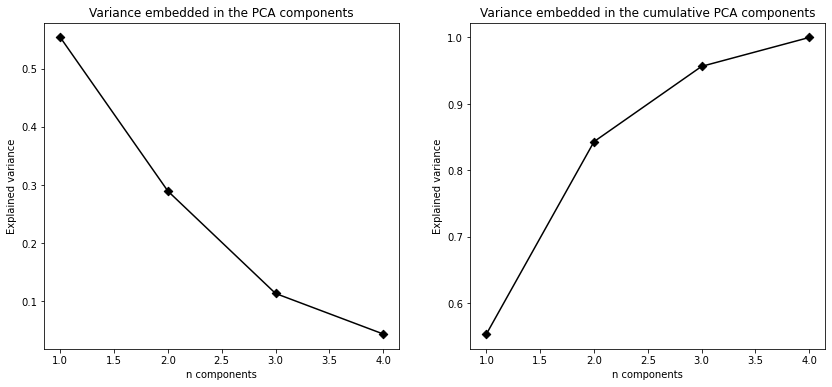

In [47]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,6))

ax[0].plot(np.arange(1,len(evals)+1),evals,color='black')
ax[0].scatter(np.arange(1,len(evals)+1),evals,color='black',marker='D')
ax[0].set_xlabel('n components')
ax[0].set_ylabel('Explained variance')
ax[0].set_title('Variance embedded in the PCA components')

ax[1].plot(np.arange(1,len(evals)+1),np.cumsum(evals),color='black')
ax[1].scatter(np.arange(1,len(evals)+1),np.cumsum(evals),color='black',marker='D')
ax[1].set_xlabel('n components')
ax[1].set_ylabel('Explained variance')
ax[1].set_title('Variance embedded in the cumulative PCA components')

Basically only three components are needed to describe $\sim 95 \%$ of the variance of the data

Now let's try to apply a classification algorithm (GMM Bayes and KNB which  resulted to be the more accurates) to the reduced PCA data (considering only the first three components.

In [48]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = sklearn.model_selection.train_test_split(X_transformed,y,test_size=0.25,train_size=0.75)

#### GMM Bayes Classification on PCAed data

In [49]:
# find the best number of components through cross-validation:
# perform Classification
scores_gmm_pca = []
nvals = np.arange(2,10)
for n in nvals:
    clf = GMMBayes(n_components=n)
    CVpred = cross_val_predict(clf, X_train_pca, y_train_pca) # use only the train data to cross-validate
    scores_gmm_pca.append(accuracy_score(y_train_pca, CVpred)) 

max score is for n = 9


Text(0.5, 1.0, 'Classification accuracy vs $N_{comp}$')

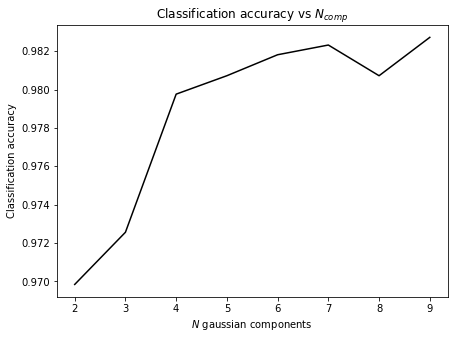

In [50]:
print("max score is for n =",nvals[np.argmax(scores_gmm_pca)])

# Plot number of neighbors vs score
fig = plt.figure(figsize=(7, 5))

plt.plot(nvals,scores_gmm_pca,color='black')
plt.xlabel('$N$ gaussian components')
plt.ylabel('Classification accuracy')
plt.title(r'Classification accuracy vs $N_{comp}$')

In [60]:
best_N_pca = nvals[np.argmax(scores_gmm_pca)]

gmm_clf_pca = GMMBayes(n_components=best_N_pca)
gmm_clf_pca.fit(X_train_pca,y_train_pca)
y_pred_gmm_pca = gmm_clf_pca.predict(X_test_pca)
y_prob_gmm_pca = gmm_clf_pca.predict_proba(X_test_pca)

In [61]:
confusion_matrix(y_test_pca,y_pred_gmm_pca)

array([[10650,   101],
       [  137,  1612]], dtype=int64)

In [62]:
completeness_gmm_pca, contamination_gmm_pca = astroML.utils.completeness_contamination(y_pred_gmm_pca, y_test_pca)

print("completeness", completeness_gmm_pca)
print("contamination", contamination_gmm_pca)

completeness 0.9216695254431103
contamination 0.05896088733216579


In [64]:
accuracy_gmm_pca = accuracy_score(y_test_pca,y_pred_gmm_pca)
print('Accuracy for GMM after PCA:',accuracy_gmm_pca)

Accuracy for GMM after PCA: 0.98096


#### K-Nearest neighbor classifier on PCAed data

In [65]:
# find the best number of components through cross-validation:
# perform Classification
scores_knc_pca = []
kvals = np.arange(1,20)
for k in kvals:
    clf = KNeighborsClassifier(n_neighbors=k)
    CVpredk = cross_val_predict(clf, X_train_pca, y_train_pca)
    scores_knc_pca.append(accuracy_score(y_train_pca, CVpredk)) 

max score is for k = 9


Text(0.5, 1.0, 'Classification accuracy vs $k_{neighbors}$ for PCAed data')

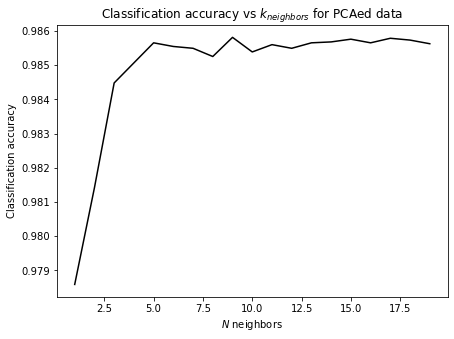

In [66]:
print("max score is for k =",kvals[np.argmax(scores_knc_pca)])

# Plot number of neighbors vs score
fig = plt.figure(figsize=(7, 5))

plt.plot(kvals,scores_knc_pca,color='black')
plt.xlabel('$N$ neighbors')
plt.ylabel('Classification accuracy')
plt.title(r'Classification accuracy vs $k_{neighbors}$ for PCAed data')

In [67]:
best_k_pca = kvals[np.argmax(scores_knc_pca)]

knc_clf_pca = KNeighborsClassifier(n_neighbors=best_k_pca)
knc_clf_pca.fit(X_train_pca,y_train_pca)
y_pred_knc_pca = knc_clf_pca.predict(X_test_pca)
y_prob_knc_pca = knc_clf_pca.predict_proba(X_test_pca)

In [68]:
confusion_matrix(y_test_pca,y_pred_knc_pca)

array([[10671,    80],
       [   92,  1657]], dtype=int64)

In [69]:
completeness_knc_pca, contamination_knc_pca = astroML.utils.completeness_contamination(y_pred_knc_pca, y_test_pca)

print("completeness", completeness_knc_pca)
print("contamination", contamination_knc_pca)

completeness 0.9473985134362493
contamination 0.04605641911341393


In [71]:
accuracy_knn_pca = accuracy_score(y_test_pca,y_pred_knc_pca)
print('Accuracy for GMM after PCA:',accuracy_knn_pca)

Accuracy for GMM after PCA: 0.98624


Compare the ROC curves of pcaed and non pcaed classifiers:

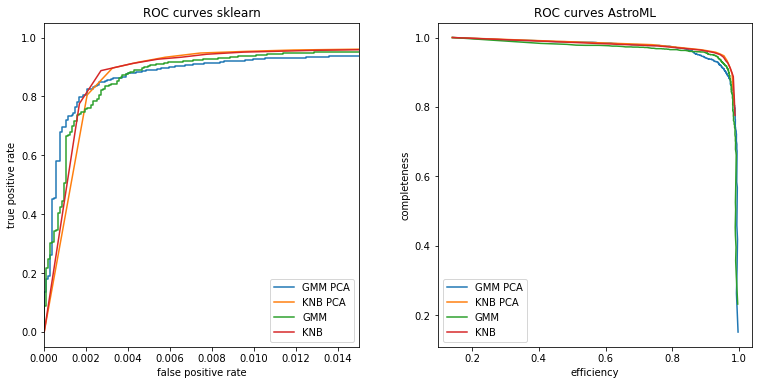

In [72]:
methods_pca = np.array(['GMM PCA','KNB PCA'])
y_probs_pca = np.array([y_prob_gmm_pca,y_prob_knc_pca])

methods = np.array(['GMM','KNB'])
y_probs = np.array([y_prob_gmm,y_prob_knc])


#plot
fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)
    
# ax1 will show roc curves
ax1 = plt.subplot(131)

# ax2 will show completeness/efficiency
ax2 = plt.subplot(132)

for label, y_prob in zip(methods_pca,y_probs_pca):
    # sklearn
    fpr, tpr, thresh = roc_curve(y_test_pca, y_prob[:,1])
    
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    #astroML
    thresholds = np.linspace(0, 1, 1001)[:-1] # grid of thresholds
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    
    for i, t in enumerate(thresholds):
        y_pred = (y_prob[:,-1] >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test_pca)
        
    
    # ROC curves sklearn
    ax1.plot(fpr,tpr,label=label)
    ax2.plot(1-cont, comp,label=label)
    
    
for label, y_prob in zip(methods,y_probs):
    # sklearn
    fpr, tpr, thresh = roc_curve(y_test, y_prob[:,1])
    
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    #astroML
    thresholds = np.linspace(0, 1, 1001)[:-1] # grid of thresholds
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    
    for i, t in enumerate(thresholds):
        y_pred = (y_prob[:,-1] >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
        
    
    # ROC curves sklearn
    ax1.plot(fpr,tpr,label=label)
    ax2.plot(1-cont, comp,label=label)
    
    
ax1.set_xlim(0,0.015)
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('ROC curves sklearn')
ax1.legend()
    
ax2.set_title('ROC curves AstroML')
ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
ax2.legend()

As we can see, the application of PCA doesn't improve significantly the classification performance.